## Problem statement

1. Train the neural network GRU/LSTM on sentiment analysis of the tweeter messages https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

In [ ]:
import torch
import re
import pandas as pd
import numpy as np
import nltk
from google.colab import drive

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from torch.utils.data import DataLoader, Dataset
from string import punctuation
from textblob import TextBlob, Word
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from itertools import islice
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Main parameters

In [ ]:
max_words = 1500
max_len = 15
num_classes = 1

# Training
epochs = 7
batch_size = 512
embedding_dim = 256
out_channel = 256

Get the main dataset for the analysis

In [ ]:
#import opendatasets as od
#import pandas

#od.download(
#    "https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech")


drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_ROOT = '/content/drive/Othercomputers/Ноутбук/PyTorch/Lesson 6. Нейросети в обработке текста'

df_train = pd.read_csv(DATA_ROOT + "/train.csv")
df_train.head()


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In this case we deal with unbalanced dataset

In [ ]:
df_train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

Train-test separation

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_train['tweet'],
                                                  df_train['label'],
                                                  test_size=0.3,
                                                  random_state=42,
                                                  stratify=df_train['label'])

### Preprocessing

In [ ]:
sw = set(stopwords.words("english"))
# Добавим к стандартному множеству еще одно слово, которое не несет смысловой нагрузки,
# но часто встречается как текстовое представление символа - &amp;
sw.add('amp')
# Добавим user, так как в данном датасете это является обезличенным
# упоминанием пользователя в твите
sw.add('user')
list(sw)[:10]

["should've",
 'not',
 'it',
 'haven',
 'were',
 "won't",
 'more',
 'own',
 'by',
 'ours']

In [ ]:
puncts = set(punctuation)
list(puncts)[:10]

['}', '!', ':', "'", '|', '$', '.', '_', ']', '`']

In [ ]:
def preprocess_text(txt):
    txt = str(txt)
    # delete symbols  ð\x9f¤\x97
    txt = "".join([c for c in txt if ord(c) < 128])
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    # preprocess "nos/nots"
    txt = re.sub("not\s", "not", txt)
    txt = re.sub("no\s", "no", txt)
    # lemmatization
    txt = [Word(word).lemmatize('v') for word in txt.split() if word not in sw]
    return " ".join(txt)

In [ ]:
X_train.iloc[:5].values

array(['happy bihday to my brother man. needed this mixtape like we need boos. have a good one sach   @user ',
       '  lang to sta the week right :)  #happiness #smile ',
       'note it meditate on it work on it ,but most impoantly trust god for it #icantwaitfohedayhisplansformylifeunfold #grateful  ',
       '@user listening to you this wet mon, ahead of #leedsmillenium gig next month   ð\x9f\x98\x86ð\x9f\x91\x8dð\x9f\x98\x8d #music #ace ',
       '@user @user agreed.. the same is true for  and .. they are overused terms, and as a result, are fast becominâ\x80¦'],
      dtype=object)

In [ ]:
X_train.iloc[:5].apply(preprocess_text).values

array(['happy bihday brother man need mixtape like need boo good one sach',
       'lang sta week right happiness smile',
       'note meditate work impoantly trust god icantwaitfohedayhisplansformylifeunfold grateful',
       'listen wet mon ahead leedsmillenium gig next month music ace',
       'agree true overuse term result fast becomin'], dtype=object)

In [ ]:
X_train = X_train.apply(preprocess_text).values
X_val = X_val.apply(preprocess_text).values

Tokenization

In [ ]:
train_corpus = " ".join(X_train)
train_corpus = train_corpus.lower()

In [ ]:
def text_to_sequence(text, maxlen, vocabulary):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

### Network Initialisation

LSTM Network

In [ ]:
class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)

        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)

        out = self.linear(last_tensor)
        out = self.dropout(out)
        # print(out.shape)
        return torch.sigmoid(out)

GRU Network

In [ ]:
class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=3, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)

        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)

        out = self.linear(last_tensor)
        out = self.dropout(out)
        # print(out.shape)
        return torch.sigmoid(out)

Custom Dataset Class

In [ ]:
class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

Functiuon for data loaders

In [ ]:
def get_loaders(max_words=2000, max_len=20):

  tokens = word_tokenize(train_corpus)
  tokens_filtered = [word for word in tokens if word.isalnum()]
  dist = FreqDist(tokens_filtered)
  tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]
  vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

  x_train = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in X_train])
  x_test = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in X_val])

  train_dataset = DataWrapper(x_train, y_train.values)
  train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

  test_dataset = DataWrapper(x_test, y_val.values)
  test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
  return train_loader, test_loader

Function for model training

In [ ]:
def learn_net(model, optimizer, train_loader, test_loader, epochs=10, th=0.5):
  model = model.to(device)
  model.train()

  train_loss_history = []
  test_loss_history = []
  train_f1_history = []
  test_f1_history = []

  for epoch in range(epochs):
      running_loss, test_loss = 0.0, 0.0
      tp_train, tn_train, fp_train, fn_train = 0.0, 0.0, 0.0, 0.0
      tp_test, tn_test, fp_test, fn_test = 0.0, 0.0, 0.0, 0.0
      pr_train, rec_train = 0.0, 0.0
      pr_test, rec_test = 0.0, 0.0
      f1_score_train, f1_score_test = 0.0, 0.0
      for i, data in enumerate(train_loader, 0):
          inputs, labels = data[0].to(device), data[1].to(device)

          # обнуляем градиент
          optimizer.zero_grad()
          outputs = model(inputs)

          loss = criterion(outputs, labels.float().view(-1, 1))
          loss.backward()
          optimizer.step()

          # подсчет ошибки на обучении
          running_loss += loss.item()
          # подсчет метрики на обучении
          pred_labels = torch.squeeze((outputs > th).int())
          tp_train += ((labels == pred_labels) & (labels == 1)).sum().item()
          tn_train += ((labels == pred_labels) & (labels == 0)).sum().item()
          fp_train += ((labels != pred_labels) & (labels == 0)).sum().item()
          fn_train += ((labels != pred_labels) & (labels == 1)).sum().item()

      # выводим статистику о процессе обучения
      model.eval()
      pr_train = tp_train / (tp_train + fp_train + .001)
      rec_train = tp_train / (tp_train + fn_train + .001)
      f1_score_train = 2 * pr_train * rec_train / (pr_train + rec_train + .001)
      print(f'Epoch [{epoch + 1}/{epochs}]. ' \
              f'Step [{i + 1}/{len(train_loader)}]. ' \
              f'Loss: {running_loss/(i+1):.3f}. ' \
              f'F1: {f1_score_train:.3f}', end='. ')

      train_loss_history.append(running_loss/(i+1))
      train_f1_history.append(f1_score_train)
      running_loss = 0.0
      tp_train, tn_train, fp_train, fn_train = 0.0, 0.0, 0.0, 0.0
      pr_train, rec_train = 0.0, 0.0
      f1_score_train = 0.0

          # выводим статистику на тестовых данных
      for j, data in enumerate(test_loader):
          test_labels = data[1].to(device)
          test_outputs = model(data[0].to(device))

          # подсчет ошибки на тесте
          test_loss += criterion(test_outputs, test_labels.float().view(-1, 1))
          # подсчет метрики на тесте
          pred_test_labels = torch.squeeze((test_outputs > th).int())
          tp_test += ((test_labels == pred_test_labels) & (test_labels == 1)).sum().item()
          tn_test += ((test_labels == pred_test_labels) & (test_labels == 0)).sum().item()
          fp_test += ((test_labels != pred_test_labels) & (test_labels == 0)).sum().item()
          fn_test += ((test_labels != pred_test_labels) & (test_labels == 1)).sum().item()

      pr_test = tp_test / (tp_test + fp_test + .001)
      rec_test = tp_test / (tp_test + fn_test + .001)
      f1_score_test = 2 * pr_test * rec_test / (pr_test + rec_test + .001)
      test_loss_history.append(test_loss.item()/(j+1))
      test_f1_history.append(f1_score_test)
      print(f'Test loss: {test_loss/(j+1):.3f}. Test F1: {f1_score_test:.3f}')
      test_loss = 0.0
      tp_test, tn_test, fp_test, fn_test = 0.0, 0.0, 0.0, 0.0
      pr_test, rec_test = 0.0, 0.0
      f1_score_test = 0.0

      model.train()

  print('Training is finished!')
  return train_loss_history, test_loss_history, train_f1_history, test_f1_history

### GRU model

In [ ]:
losses_train = []
losses_test = []
f1_list_train = []
f1_list_test = []
for i in [10, 15, 20, 25]:
  train_loader, test_loader = get_loaders(max_words=2000, max_len=i)
  model = GRUFixedLen(vocab_size=2000)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = nn.BCELoss()
  train_loss_history, test_loss_history, train_f1_history, test_f1_history = learn_net(model, optimizer, train_loader, test_loader)
  losses_train.append(train_loss_history)
  losses_test.append(test_loss_history)
  f1_list_train.append(train_f1_history)
  f1_list_test.append(test_f1_history)

Epoch [1/10]. Step [44/44]. Loss: 0.359. F1: 0.037. Test loss: 0.243. Test F1: 0.003
Epoch [2/10]. Step [44/44]. Loss: 0.319. F1: 0.147. Test loss: 0.232. Test F1: 0.285
Epoch [3/10]. Step [44/44]. Loss: 0.299. F1: 0.302. Test loss: 0.191. Test F1: 0.374
Epoch [4/10]. Step [44/44]. Loss: 0.274. F1: 0.404. Test loss: 0.164. Test F1: 0.459
Epoch [5/10]. Step [44/44]. Loss: 0.255. F1: 0.489. Test loss: 0.172. Test F1: 0.568
Epoch [6/10]. Step [44/44]. Loss: 0.242. F1: 0.538. Test loss: 0.155. Test F1: 0.544
Epoch [7/10]. Step [44/44]. Loss: 0.236. F1: 0.573. Test loss: 0.156. Test F1: 0.598
Epoch [8/10]. Step [44/44]. Loss: 0.231. F1: 0.588. Test loss: 0.162. Test F1: 0.554
Epoch [9/10]. Step [44/44]. Loss: 0.224. F1: 0.609. Test loss: 0.157. Test F1: 0.565
Epoch [10/10]. Step [44/44]. Loss: 0.219. F1: 0.608. Test loss: 0.158. Test F1: 0.571
Training is finished!
Epoch [1/10]. Step [44/44]. Loss: 0.332. F1: 0.174. Test loss: 0.183. Test F1: 0.513
Epoch [2/10]. Step [44/44]. Loss: 0.263. F

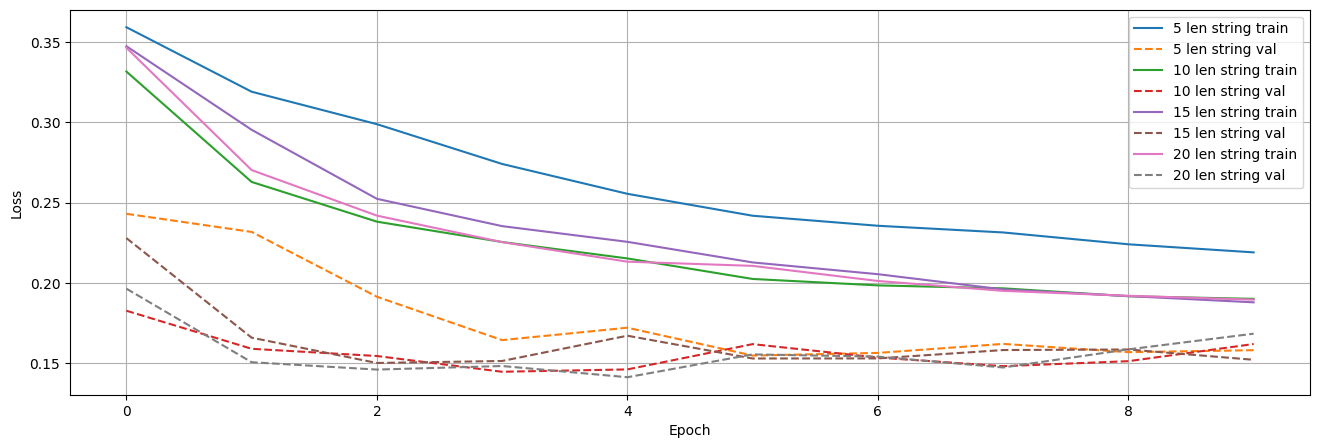

In [ ]:
plt.figure(figsize = (16,5))
for i in range(4):
    plt.plot(losses_train[i],'-',label = f'{5+(i + 1) * 5} len string train')
    plt.plot(losses_test[i],'--',label = f'{5+(i + 1) * 5} len string val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

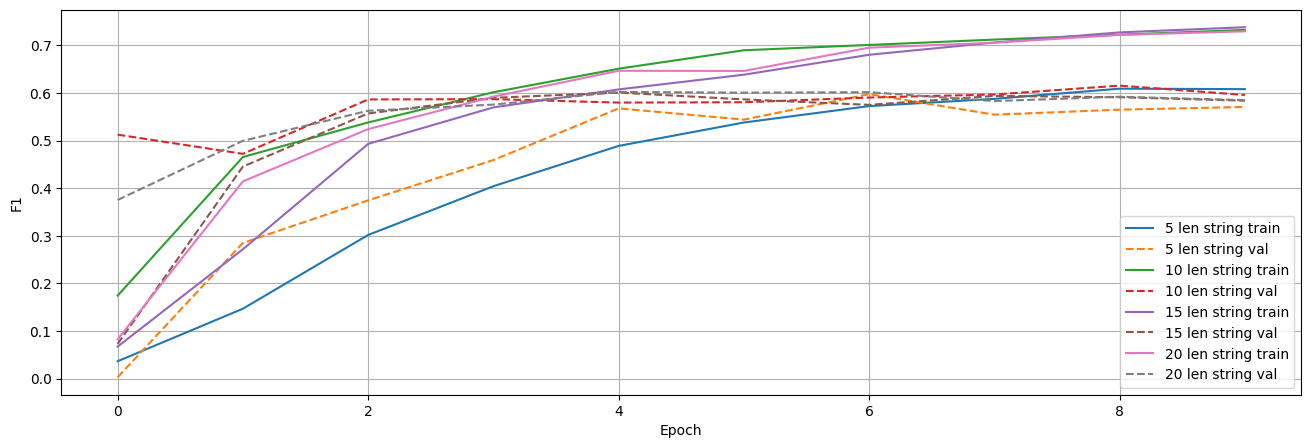

In [ ]:
plt.figure(figsize = (16,5))
for i in range(4):
    plt.plot(f1_list_train[i],'-',label = f'{5+(i + 1) * 5} len string train')
    plt.plot(f1_list_test[i],'--',label = f'{5+(i + 1) * 5} len string val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid()
plt.show()

### LSTM Model

In [ ]:
losses_train = []
losses_test = []
f1_list_train = []
f1_list_test = []
for i in [10, 15, 20, 25]:
  train_loader, test_loader = get_loaders(max_words=2000, max_len=i)
  model = LSTMFixedLen(vocab_size=2000)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = nn.BCELoss()
  train_loss_history, test_loss_history, train_f1_history, test_f1_history = learn_net(model, optimizer, train_loader, test_loader)
  losses_train.append(train_loss_history)
  losses_test.append(test_loss_history)
  f1_list_train.append(train_f1_history)
  f1_list_test.append(test_f1_history)

Epoch [1/10]. Step [44/44]. Loss: 0.322. F1: 0.242. Test loss: 0.178. Test F1: 0.424
Epoch [2/10]. Step [44/44]. Loss: 0.264. F1: 0.416. Test loss: 0.153. Test F1: 0.544
Epoch [3/10]. Step [44/44]. Loss: 0.237. F1: 0.542. Test loss: 0.150. Test F1: 0.564
Epoch [4/10]. Step [44/44]. Loss: 0.222. F1: 0.595. Test loss: 0.145. Test F1: 0.605
Epoch [5/10]. Step [44/44]. Loss: 0.208. F1: 0.632. Test loss: 0.150. Test F1: 0.592
Epoch [6/10]. Step [44/44]. Loss: 0.204. F1: 0.649. Test loss: 0.153. Test F1: 0.592
Epoch [7/10]. Step [44/44]. Loss: 0.192. F1: 0.692. Test loss: 0.164. Test F1: 0.592
Epoch [8/10]. Step [44/44]. Loss: 0.186. F1: 0.745. Test loss: 0.177. Test F1: 0.597
Epoch [9/10]. Step [44/44]. Loss: 0.185. F1: 0.756. Test loss: 0.172. Test F1: 0.570
Epoch [10/10]. Step [44/44]. Loss: 0.181. F1: 0.754. Test loss: 0.170. Test F1: 0.585
Training is finished!
Epoch [1/10]. Step [44/44]. Loss: 0.331. F1: 0.173. Test loss: 0.186. Test F1: 0.475
Epoch [2/10]. Step [44/44]. Loss: 0.280. F

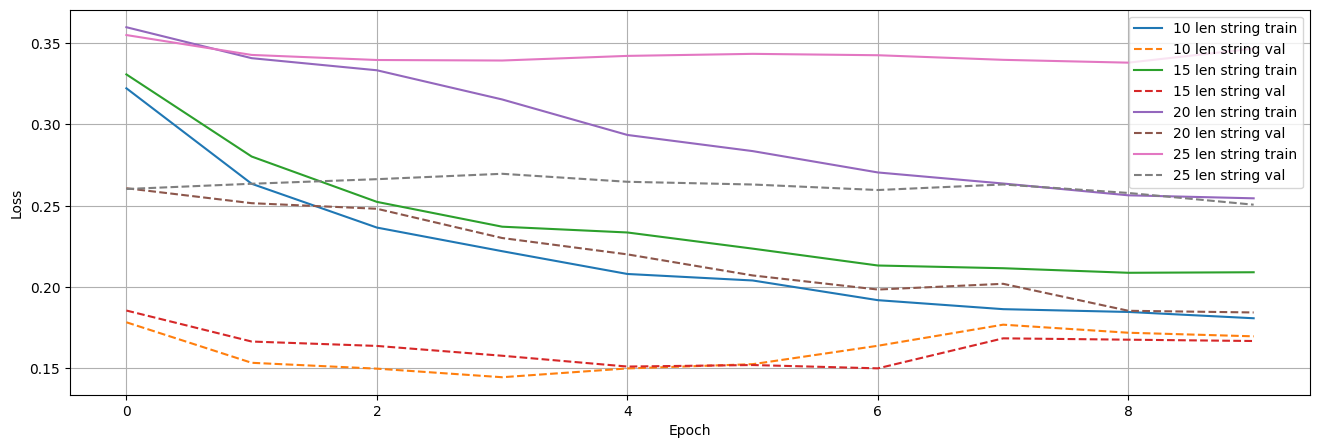

In [ ]:
plt.figure(figsize = (16,5))
for i in range(4):
    plt.plot(losses_train[i],'-',label = f'{5+(i + 1) * 5} len string train')
    plt.plot(losses_test[i],'--',label = f'{5+(i + 1) * 5} len string val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

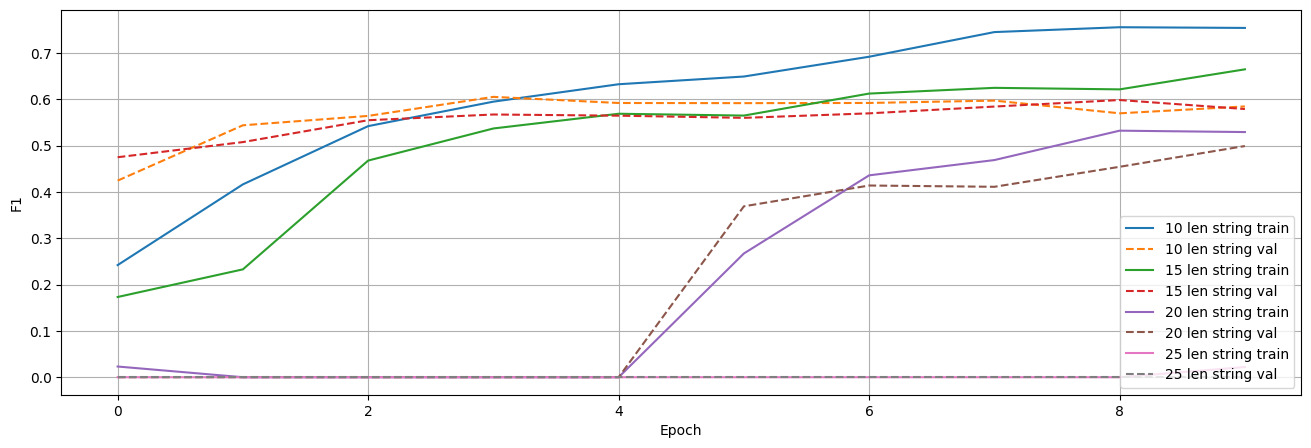

In [ ]:
plt.figure(figsize = (16,5))
for i in range(4):
    plt.plot(f1_list_train[i],'-',label = f'{5+(i + 1) * 5} len string train')
    plt.plot(f1_list_test[i],'--',label = f'{5+(i + 1) * 5} len string val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid()
plt.show()

In this case the best result is achieved using 10-token length. Let's try to change the use_last parameter

In [ ]:
losses_train = []
losses_test = []
f1_list_train = []
f1_list_test = []
for i in [True, False]:
  train_loader, test_loader = get_loaders(max_words=2000, max_len=10)
  model = LSTMFixedLen(vocab_size=2000, use_last=i)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = nn.BCELoss()
  train_loss_history, test_loss_history, train_f1_history, test_f1_history = learn_net(model, optimizer, train_loader, test_loader)
  losses_train.append(train_loss_history)
  losses_test.append(test_loss_history)
  f1_list_train.append(train_f1_history)
  f1_list_test.append(test_f1_history)

Epoch [1/10]. Step [44/44]. Loss: 0.309. F1: 0.311. Test loss: 0.165. Test F1: 0.392
Epoch [2/10]. Step [44/44]. Loss: 0.253. F1: 0.531. Test loss: 0.145. Test F1: 0.578
Epoch [3/10]. Step [44/44]. Loss: 0.232. F1: 0.592. Test loss: 0.159. Test F1: 0.595
Epoch [4/10]. Step [44/44]. Loss: 0.217. F1: 0.642. Test loss: 0.143. Test F1: 0.609
Epoch [5/10]. Step [44/44]. Loss: 0.202. F1: 0.671. Test loss: 0.158. Test F1: 0.587
Epoch [6/10]. Step [44/44]. Loss: 0.199. F1: 0.688. Test loss: 0.146. Test F1: 0.600
Epoch [7/10]. Step [44/44]. Loss: 0.196. F1: 0.725. Test loss: 0.154. Test F1: 0.601
Epoch [8/10]. Step [44/44]. Loss: 0.190. F1: 0.750. Test loss: 0.181. Test F1: 0.595
Epoch [9/10]. Step [44/44]. Loss: 0.182. F1: 0.754. Test loss: 0.181. Test F1: 0.605
Epoch [10/10]. Step [44/44]. Loss: 0.175. F1: 0.782. Test loss: 0.178. Test F1: 0.611
Training is finished!
Epoch [1/10]. Step [44/44]. Loss: 0.307. F1: 0.277. Test loss: 0.157. Test F1: 0.534
Epoch [2/10]. Step [44/44]. Loss: 0.251. F

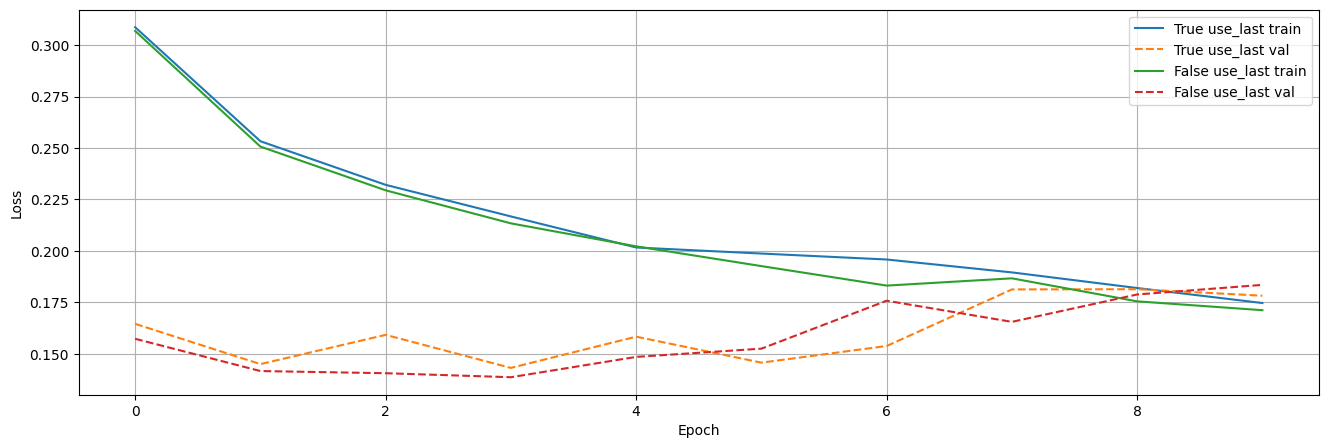

In [ ]:
plt.figure(figsize = (16,5))
for i in range(2):
    use_last = 'True'
    if i != 0:
      use_last = 'False'
    plt.plot(losses_train[i],'-',label = f'{use_last} use_last train')
    plt.plot(losses_test[i],'--',label = f'{use_last} use_last val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

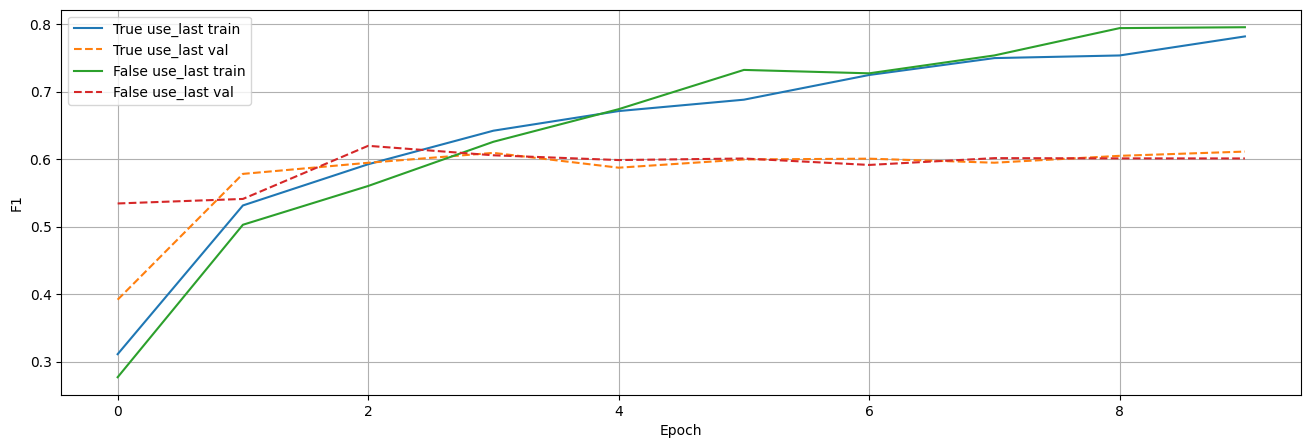

In [ ]:
plt.figure(figsize = (16,5))
for i in range(2):
    use_last = 'True'
    if i != 0:
      use_last = 'False'
    plt.plot(f1_list_train[i],'-',label = f'{use_last} use_last train')
    plt.plot(f1_list_test[i],'--',label = f'{use_last} use_last val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid()
plt.show()